# Compute Stochastic Reconstruction Loss with Component Subsets

Load an SPD decomposition and compute reconstruction loss using only specific subsets of components,
selected via regex patterns (like `target_module_patterns` in SPD config).

In [ ]:
import sys
import re
from pathlib import Path
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Optional
from fnmatch import fnmatch

# Add parent directory to path
sys.path.append(str(Path.cwd().parent.parent))

from spd.models.component_model import ComponentModel
from spd.data import DatasetConfig, create_data_loader
from spd.utils.component_utils import calc_stochastic_masks, calc_ci_l_zero
from spd.losses import calc_masked_recon_loss
from spd.utils.general_utils import set_seed

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/mnt/polished-lake/home/nhu/spd/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Configuration

In [ ]:
# REQUIRED: Your WandB run path
WANDB_RUN_PATH = "wandb:spd/runs/3z96xvys"  # e.g., "wandb:spd/runs/abc123"

# Data settings
BATCH_SIZE = 8
MAX_SEQ_LEN = 512
N_EVAL_BATCHES = 20  # Number of batches to evaluate
N_MASK_SAMPLES = 5   # Number of stochastic mask samples per subset

# Seed for reproducibility
SEED = 42
set_seed(SEED)

## Load Model and Data

In [4]:
# Load model
print(f"Loading model from: {WANDB_RUN_PATH}")
model = ComponentModel.from_pretrained(WANDB_RUN_PATH)
model = model.to(device)
model.eval()

print(f"\nModel loaded!")
print(f"Number of components per module: {model.C}")
print(f"Total modules: {len(model.components)}")
print(f"\nAll target modules:")
for i, module_name in enumerate(model.components.keys()):
    print(f"  {i:2d}. {module_name}")

Loading model from: wandb:spd/runs/3z96xvys

Model loaded!
Number of components per module: 4000
Total modules: 28

All target modules:
   0. model.layers.0.self_attn.q_proj
   1. model.layers.0.self_attn.k_proj
   2. model.layers.0.self_attn.v_proj
   3. model.layers.0.self_attn.o_proj
   4. model.layers.0.mlp.gate_proj
   5. model.layers.0.mlp.up_proj
   6. model.layers.0.mlp.down_proj
   7. model.layers.1.self_attn.q_proj
   8. model.layers.1.self_attn.k_proj
   9. model.layers.1.self_attn.v_proj
  10. model.layers.1.self_attn.o_proj
  11. model.layers.1.mlp.gate_proj
  12. model.layers.1.mlp.up_proj
  13. model.layers.1.mlp.down_proj
  14. model.layers.2.self_attn.q_proj
  15. model.layers.2.self_attn.k_proj
  16. model.layers.2.self_attn.v_proj
  17. model.layers.2.self_attn.o_proj
  18. model.layers.2.mlp.gate_proj
  19. model.layers.2.mlp.up_proj
  20. model.layers.2.mlp.down_proj
  21. model.layers.3.self_attn.q_proj
  22. model.layers.3.self_attn.k_proj
  23. model.layers.3.se

In [5]:
data_config = DatasetConfig(
    name="SimpleStories/SimpleStories",
    hf_tokenizer_path="SimpleStories/SimpleStories-1.25M",
    split="test",
    n_ctx=MAX_SEQ_LEN,
    is_tokenized=False,
    streaming=False,
    column_name="story",
)

print("Loading SimpleStories dataset...")
eval_loader, tokenizer = create_data_loader(
    dataset_config=data_config,
    batch_size=BATCH_SIZE,
    buffer_size=1000,
    global_seed=SEED,
)
print("Dataset loaded!")

Loading SimpleStories dataset...
Dataset loaded!


## Define Component Subsets

Define different subsets of components using patterns (same format as `target_module_patterns`).
Each pattern will be evaluated separately.

In [6]:
# Define component subset patterns to evaluate
# These use the same format as target_module_patterns in SPD configs
COMPONENT_SUBSETS = {
    "all": ["*"],  # All components

    "all_but_l0": [
        "model.layers.1.*",
        "model.layers.2.*",
        "model.layers.3.*",
    ],
    "all_but_l1": [
        "model.layers.0.*",
        "model.layers.2.*",
        "model.layers.3.*",
    ],
    "all_but_l2": [
        "model.layers.0.*",
        "model.layers.1.*",
        "model.layers.3.*",
    ],
    "all_but_l3": [
        "model.layers.0.*",
        "model.layers.1.*",
        "model.layers.2.*",
    ],
    "l0_only": ["model.layers.0.*"],
    "l1_only": ["model.layers.1.*"],
    "l2_only": ["model.layers.2.*"],
    "l3_only": ["model.layers.3.*"],
}

for c in model.components.keys():
    if 'mlp' in c:
        short_name = c.replace('model.layers.', '')
        COMPONENT_SUBSETS[f'{short_name}_only'] = [c]
        COMPONENT_SUBSETS[f'all_but_{short_name}'] = [x for x in model.components.keys() if x != c]

## Helper Functions

In [ ]:
def match_module_patterns(module_names: List[str], patterns: List[str]) -> List[str]:
    """Match module names against patterns (supporting * wildcards)."""
    matched = []
    for module_name in module_names:
        for pattern in patterns:
            if fnmatch(module_name, pattern):
                matched.append(module_name)
                break
    return matched


def create_subset_masks(
    model: ComponentModel,
    pre_weight_acts: dict,
    module_patterns: List[str],
    n_samples: int = 1,
    use_all_ones_for_non_replaced: bool = False,
) -> List[Dict[str, torch.Tensor]]:
    """
    Create stochastic masks for modules matching the patterns.
    
    Args:
        model: ComponentModel
        pre_weight_acts: Pre-weight activations from forward pass
        module_patterns: List of module patterns to include (e.g., ["*.mlp.*"])
        n_samples: Number of stochastic samples
        use_all_ones_for_non_replaced: If True, use all-ones mask for non-matched modules.
                                        If False, non-matched modules won't have mask entries (use original weights).
    
    Returns:
        List of mask dictionaries
    """
    # Get modules matching the patterns
    all_modules = list(model.components.keys())
    active_modules = match_module_patterns(all_modules, module_patterns)
    
    # Calculate causal importances
    causal_importances, _ = model.calc_causal_importances(
        pre_weight_acts=pre_weight_acts,
        sigmoid_type="leaky_hard",
        detach_inputs=True,
    )
    
    # Generate stochastic masks
    stochastic_masks = calc_stochastic_masks(
        causal_importances=causal_importances,
        n_mask_samples=n_samples,
    )
    
    # Create subset masks
    subset_masks = []
    for mask_dict in stochastic_masks:
        subset_mask = {}
        for module_name in all_modules:
            if module_name in active_modules:
                # Use stochastic mask for active modules
                subset_mask[module_name] = mask_dict[module_name]
            elif use_all_ones_for_non_replaced:
                # Use all-ones mask for non-active modules
                subset_mask[module_name] = torch.ones_like(mask_dict[module_name])
        # If use_all_ones_for_non_replaced is False, non-matched modules won't have entries
        subset_masks.append(subset_mask)
    
    return subset_masks

## Compute Reconstruction Loss for Each Subset

In [ ]:
import torch.nn.functional as F

def evaluate_subset_reconstruction(
    model: ComponentModel,
    eval_loader,
    module_patterns: List[str],
    n_batches: int = 10,
    n_mask_samples: int = 5,
    use_all_ones_for_non_replaced: bool = False,
) -> Dict[str, float]:
    """
    Evaluate reconstruction loss using only specified component subsets.
    
    Returns:
        Dictionary with both KL and CE loss statistics
    """
    kl_losses = []
    ce_losses = []
    ce_unrecovered = []
    
    # We need to compute target and zero-masked CE for CE unrecovered calculation
    target_ce_total = 0
    zero_ce_total = 0
    n_batches_processed = 0
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(eval_loader, total=n_batches)):
            if batch_idx >= n_batches:
                break
            
            # Extract input_ids from batch dictionary
            if isinstance(batch_data, dict):
                batch = batch_data['input_ids'].to(device)
            elif isinstance(batch_data, tuple):
                batch = batch_data[0].to(device)
            else:
                batch = batch_data.to(device)
            
            # Get target output AND pre-weight activations
            target_out, pre_weight_acts = model(
                batch,
                mode="pre_forward_cache",
                module_names=model.target_module_paths,
            )
            
            # Create masks for this subset
            masks = create_subset_masks(
                model=model,
                pre_weight_acts=pre_weight_acts,
                module_patterns=module_patterns,
                n_samples=n_mask_samples,
                use_all_ones_for_non_replaced=use_all_ones_for_non_replaced,
            )
            
            # Prepare labels for CE calculation
            masked_batch = batch.clone()
            masked_batch[:, 0] = -100  # Can't predict first token
            flat_masked_batch = masked_batch.flatten()
            
            def ce_vs_labels(logits: torch.Tensor) -> float:
                flat_logits = einops.rearrange(logits, "b seq_len vocab -> (b seq_len) vocab")
                return F.cross_entropy(
                    flat_logits[:-1], flat_masked_batch[1:], ignore_index=-100
                ).item()
            
            # Compute target model CE (for reference)
            target_ce = ce_vs_labels(target_out)
            target_ce_total += target_ce
            
            # Compute zero-masked CE (for CE unrecovered calculation)
            causal_importances, _ = model.calc_causal_importances(
                pre_weight_acts=pre_weight_acts,
                sigmoid_type="leaky_hard",
                detach_inputs=True,
            )
            zero_masks = {k: torch.zeros_like(v) for k, v in causal_importances.items()}
            zero_out = model(batch, mode="components", masks=zero_masks)
            zero_ce = ce_vs_labels(zero_out)
            zero_ce_total += zero_ce
            
            # Compute losses for each mask sample
            batch_kl_losses = []
            batch_ce_losses = []
            for mask in masks:
                # Get output with mask
                masked_out = model(batch, mode="components", masks=mask)
                
                # KL loss
                from spd.utils.general_utils import calc_kl_divergence_lm
                kl_loss = calc_kl_divergence_lm(pred=masked_out, target=target_out)
                batch_kl_losses.append(kl_loss.item())
                
                # CE loss
                ce_loss = ce_vs_labels(masked_out)
                batch_ce_losses.append(ce_loss)
            
            mean_ce = np.mean(batch_ce_losses)
            kl_losses.append(np.mean(batch_kl_losses))
            ce_losses.append(mean_ce)
            
            # Calculate CE unrecovered percentage for this batch
            if zero_ce != target_ce:  # Avoid division by zero
                pct_unrecovered = (mean_ce - target_ce) / (zero_ce - target_ce)
                ce_unrecovered.append(pct_unrecovered)
            
            n_batches_processed += 1
    
    # Calculate average target and zero CE
    avg_target_ce = target_ce_total / n_batches_processed if n_batches_processed > 0 else 0
    avg_zero_ce = zero_ce_total / n_batches_processed if n_batches_processed > 0 else 0
    
    return {
        "kl_mean": np.mean(kl_losses),
        "kl_std": np.std(kl_losses),
        "kl_min": np.min(kl_losses),
        "kl_max": np.max(kl_losses),
        "ce_mean": np.mean(ce_losses),
        "ce_std": np.std(ce_losses),
        "ce_min": np.min(ce_losses),
        "ce_max": np.max(ce_losses),
        "ce_unrecovered_mean": np.mean(ce_unrecovered) if ce_unrecovered else 0,
        "ce_unrecovered_std": np.std(ce_unrecovered) if ce_unrecovered else 0,
        "target_ce": avg_target_ce,
        "zero_ce": avg_zero_ce,
    }

In [ ]:
# Evaluate all component subsets with both masking modes
results_original = {}  # Using original weights for non-replaced modules
results_all_ones = {}  # Using all-ones masks for non-replaced modules

for subset_name, patterns in COMPONENT_SUBSETS.items():
    print(f"\n{'='*60}")
    print(f"Evaluating subset: {subset_name}")
    print(f"  Patterns: {patterns}")
    
    # Show which modules match
    matched_modules = match_module_patterns(list(model.components.keys()), patterns)
    print(f"  Matched {len(matched_modules)} modules")
    
    # Evaluate with original weights for non-replaced modules
    print(f"\n  Mode 1: Original weights for non-replaced modules")
    subset_results_original = evaluate_subset_reconstruction(
        model=model,
        eval_loader=eval_loader,
        module_patterns=patterns,
        n_batches=N_EVAL_BATCHES,
        n_mask_samples=N_MASK_SAMPLES,
        use_all_ones_for_non_replaced=False,
    )
    results_original[subset_name] = subset_results_original
    print(f"    KL Loss: {subset_results_original['kl_mean']:.4f} ± {subset_results_original['kl_std']:.4f}")
    print(f"    CE Loss: {subset_results_original['ce_mean']:.4f} ± {subset_results_original['ce_std']:.4f}")
    print(f"    CE Unrecovered: {subset_results_original['ce_unrecovered_mean']:.2%} ± {subset_results_original['ce_unrecovered_std']:.2%}")
    
    # Evaluate with all-ones masks for non-replaced modules
    print(f"\n  Mode 2: All-ones masks for non-replaced modules")
    subset_results_all_ones = evaluate_subset_reconstruction(
        model=model,
        eval_loader=eval_loader,
        module_patterns=patterns,
        n_batches=N_EVAL_BATCHES,
        n_mask_samples=N_MASK_SAMPLES,
        use_all_ones_for_non_replaced=True,
    )
    results_all_ones[subset_name] = subset_results_all_ones
    print(f"    KL Loss: {subset_results_all_ones['kl_mean']:.4f} ± {subset_results_all_ones['kl_std']:.4f}")
    print(f"    CE Loss: {subset_results_all_ones['ce_mean']:.4f} ± {subset_results_all_ones['ce_std']:.4f}")
    print(f"    CE Unrecovered: {subset_results_all_ones['ce_unrecovered_mean']:.2%} ± {subset_results_all_ones['ce_unrecovered_std']:.2%}")

## Results Summary

/tmp/ipykernel_2667570/3060079812.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([n.replace('all_but_', '') for n in names2])


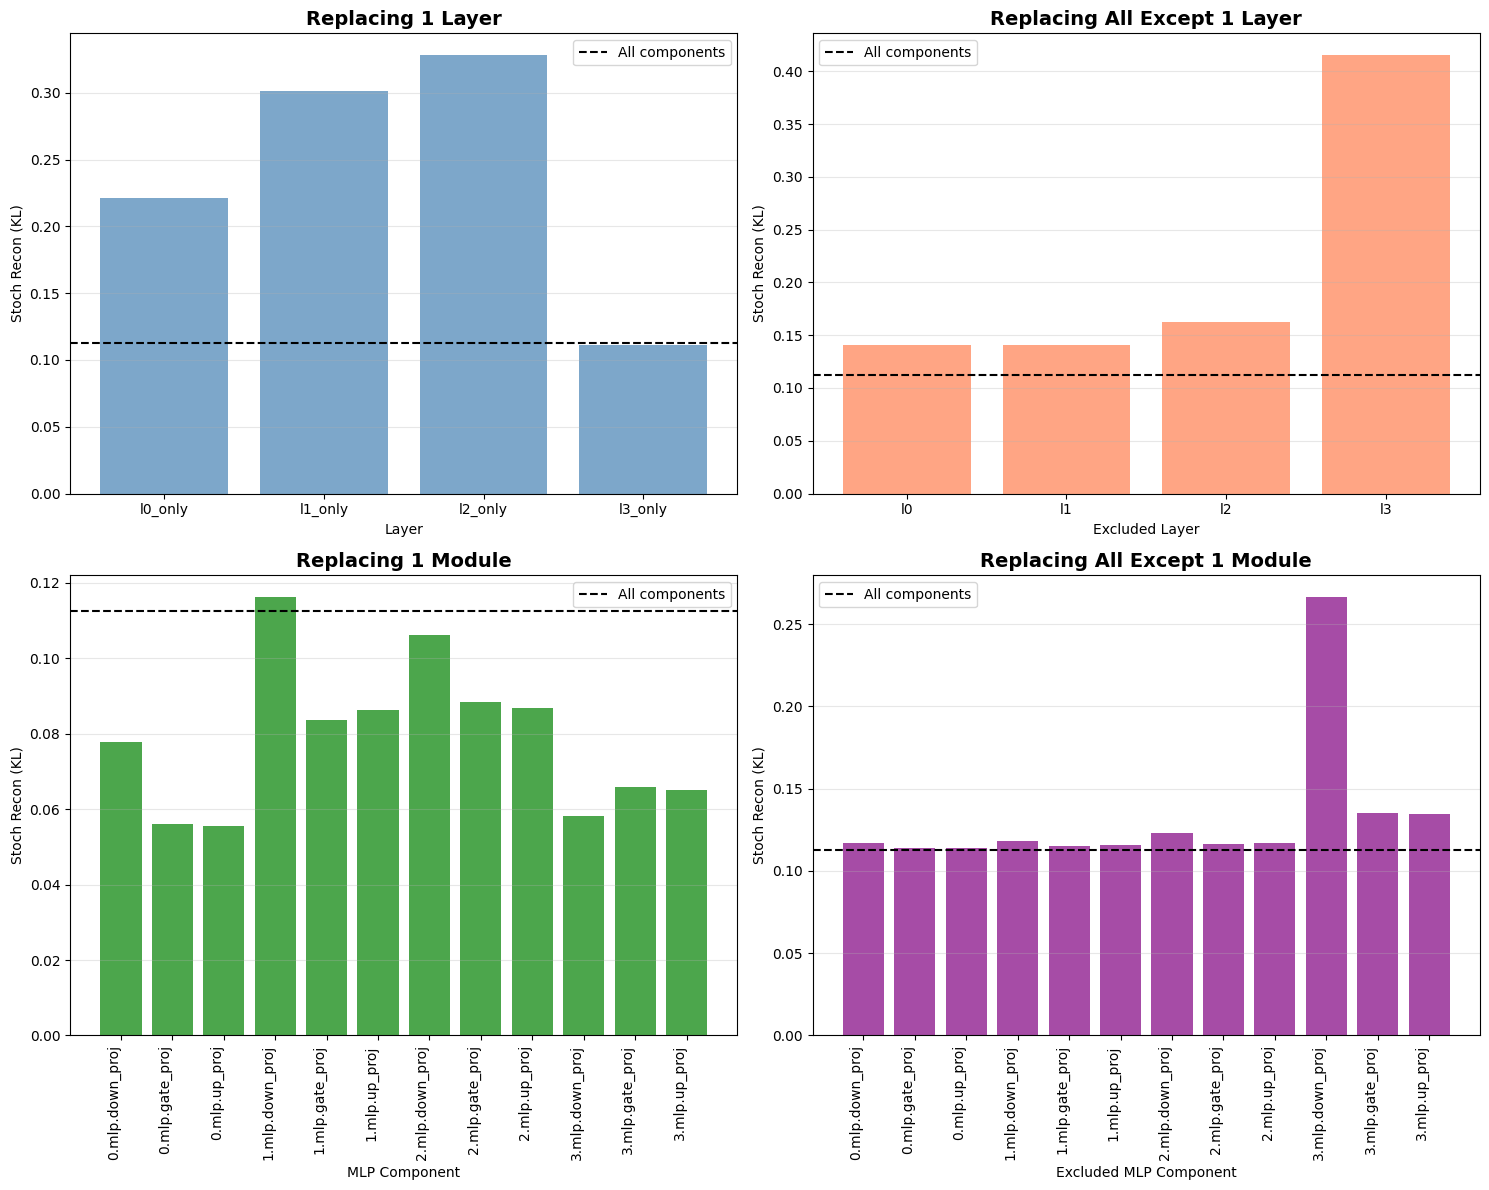

In [15]:
import matplotlib.pyplot as plt

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Get the "all" baseline for reference line
all_baseline = results["all"]["mean"]

# 1. Layer-only subsets (top left)
layer_only = {k: v for k, v in results.items() if k.endswith('_only') and k[0] == 'l'}
layer_only = dict(sorted(layer_only.items()))  # Sort by name

ax1 = axes[0, 0]
names1 = list(layer_only.keys())
values1 = [layer_only[k]["mean"] for k in names1]
bars1 = ax1.bar(names1, values1, color='steelblue', alpha=0.7)
ax1.axhline(y=all_baseline, color='black', linestyle='--', label='All components')
ax1.set_title('Replacing 1 Layer', fontsize=14, fontweight='bold')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Stoch Recon (KL)')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. All-but-layer subsets (top right)
all_but_layer = {k: v for k, v in results.items() if k.startswith('all_but_l')}
all_but_layer = dict(sorted(all_but_layer.items()))

ax2 = axes[0, 1]
names2 = list(all_but_layer.keys())
values2 = [all_but_layer[k]["mean"] for k in names2]
bars2 = ax2.bar(names2, values2, color='coral', alpha=0.7)
ax2.axhline(y=all_baseline, color='black', linestyle='--', label='All components')
ax2.set_title('Replacing All Except 1 Layer', fontsize=14, fontweight='bold')
ax2.set_xlabel('Excluded Layer')
ax2.set_ylabel('Stoch Recon (KL)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels([n.replace('all_but_', '') for n in names2])

# 3. Individual MLP components (bottom left)
mlp_only = {k: v for k, v in results.items()
            if 'mlp' in k and k.endswith('_only') and not k.startswith('l')}
mlp_only = dict(sorted(mlp_only.items()))

ax3 = axes[1, 0]
names3 = list(mlp_only.keys())
values3 = [mlp_only[k]["mean"] for k in names3]
bars3 = ax3.bar(range(len(names3)), values3, color='green', alpha=0.7)
ax3.axhline(y=all_baseline, color='black', linestyle='--', label='All components')
ax3.set_title('Replacing 1 Module', fontsize=14, fontweight='bold')
ax3.set_xlabel('MLP Component')
ax3.set_ylabel('Stoch Recon (KL)')
ax3.set_xticks(range(len(names3)))
ax3.set_xticklabels([n.replace('_only', '') for n in names3], rotation=90, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. All-but individual MLP components (bottom right)
all_but_mlp = {k: v for k, v in results.items()
                if k.startswith('all_but_') and 'mlp' in k}
all_but_mlp = dict(sorted(all_but_mlp.items()))

ax4 = axes[1, 1]
names4 = list(all_but_mlp.keys())
values4 = [all_but_mlp[k]["mean"] for k in names4]
bars4 = ax4.bar(range(len(names4)), values4, color='purple', alpha=0.7)
ax4.axhline(y=all_baseline, color='black', linestyle='--', label='All components')
ax4.set_title('Replacing All Except 1 Module', fontsize=14, fontweight='bold')
ax4.set_xlabel('Excluded MLP Component')
ax4.set_ylabel('Stoch Recon (KL)')
ax4.set_xticks(range(len(names4)))
ax4.set_xticklabels([n.replace('all_but_', '') for n in names4], rotation=90, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Create first figure with KL loss comparisons (2x2 grid)
fig1, axes1 = plt.subplots(2, 2, figsize=(15, 12))

# Get the "all" baseline for reference line
all_baseline_original = results_original["all"]["kl_mean"]
all_baseline_all_ones = results_all_ones["all"]["kl_mean"]

# Helper function to plot bars with both modes
def plot_comparison(ax, data_dict_original, data_dict_all_ones, title, xlabel, color):
    names = list(data_dict_original.keys())
    x = np.arange(len(names))
    width = 0.35
    
    values_original = [data_dict_original[k]["kl_mean"] for k in names]
    values_all_ones = [data_dict_all_ones[k]["kl_mean"] for k in names]
    
    bars1 = ax.bar(x - width/2, values_original, width, label='Original weights', color=color, alpha=0.6)
    bars2 = ax.bar(x + width/2, values_all_ones, width, label='All-ones mask', color=color, alpha=0.9)
    
    ax.axhline(y=all_baseline_original, color='black', linestyle='--', alpha=0.5, label='All components (original)')
    ax.axhline(y=all_baseline_all_ones, color='gray', linestyle='--', alpha=0.5, label='All components (all-ones)')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Stoch Recon (KL)')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    return ax

# 1. Layer-only subsets (top left)
layer_only_orig = {k: v for k, v in results_original.items() if k.endswith('_only') and k[0] == 'l'}
layer_only_ones = {k: v for k, v in results_all_ones.items() if k.endswith('_only') and k[0] == 'l'}
layer_only_orig = dict(sorted(layer_only_orig.items()))
layer_only_ones = dict(sorted(layer_only_ones.items()))

plot_comparison(axes1[0, 0], layer_only_orig, layer_only_ones, 
                'Replacing 1 Layer', 'Layer', 'steelblue')

# 2. All-but-layer subsets (top right)
all_but_layer_orig = {k: v for k, v in results_original.items() if k.startswith('all_but_l')}
all_but_layer_ones = {k: v for k, v in results_all_ones.items() if k.startswith('all_but_l')}
all_but_layer_orig = dict(sorted(all_but_layer_orig.items()))
all_but_layer_ones = dict(sorted(all_but_layer_ones.items()))

ax2 = plot_comparison(axes1[0, 1], all_but_layer_orig, all_but_layer_ones,
                      'Replacing All Except 1 Layer', 'Excluded Layer', 'coral')
ax2.set_xticklabels([n.replace('all_but_', '') for n in all_but_layer_orig.keys()], rotation=45, ha='right')

# 3. Individual MLP components (bottom left)
mlp_only_orig = {k: v for k, v in results_original.items()
                 if 'mlp' in k and k.endswith('_only') and not k.startswith('l')}
mlp_only_ones = {k: v for k, v in results_all_ones.items()
                 if 'mlp' in k and k.endswith('_only') and not k.startswith('l')}
mlp_only_orig = dict(sorted(mlp_only_orig.items()))
mlp_only_ones = dict(sorted(mlp_only_ones.items()))

ax3 = plot_comparison(axes1[1, 0], mlp_only_orig, mlp_only_ones,
                      'Replacing 1 Module', 'MLP Component', 'green')
ax3.set_xticklabels([n.replace('_only', '') for n in mlp_only_orig.keys()], rotation=90, ha='right')

# 4. All-but individual MLP components (bottom right)
all_but_mlp_orig = {k: v for k, v in results_original.items()
                    if k.startswith('all_but_') and 'mlp' in k}
all_but_mlp_ones = {k: v for k, v in results_all_ones.items()
                    if k.startswith('all_but_') and 'mlp' in k}
all_but_mlp_orig = dict(sorted(all_but_mlp_orig.items()))
all_but_mlp_ones = dict(sorted(all_but_mlp_ones.items()))

ax4 = plot_comparison(axes1[1, 1], all_but_mlp_orig, all_but_mlp_ones,
                      'Replacing All Except 1 Module', 'Excluded MLP Component', 'purple')
ax4.set_xticklabels([n.replace('all_but_', '') for n in all_but_mlp_orig.keys()], rotation=90, ha='right')

plt.suptitle('KL Loss Comparison: Original Weights vs All-Ones Masks', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create second figure with CE unrecovered comparisons (2x2 grid)
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))

# Get the "all" baseline for CE unrecovered reference lines
all_ce_baseline_original = results_original["all"]["ce_unrecovered_mean"]
all_ce_baseline_all_ones = results_all_ones["all"]["ce_unrecovered_mean"]

def plot_ce_comparison(ax, data_dict_original, data_dict_all_ones, title, xlabel, color):
    names = list(data_dict_original.keys())
    x = np.arange(len(names))
    width = 0.35
    
    # Use raw values (not percentages)
    values_original = [data_dict_original[k]["ce_unrecovered_mean"] for k in names]
    values_all_ones = [data_dict_all_ones[k]["ce_unrecovered_mean"] for k in names]
    
    bars1 = ax.bar(x - width/2, values_original, width, label='Original weights', color=color, alpha=0.6)
    bars2 = ax.bar(x + width/2, values_all_ones, width, label='All-ones mask', color=color, alpha=0.9)
    
    # Add horizontal dotted reference lines
    ax.axhline(y=all_ce_baseline_original, color='black', linestyle=':', alpha=0.5, label='All components (original)')
    ax.axhline(y=all_ce_baseline_all_ones, color='gray', linestyle=':', alpha=0.5, label='All components (all-ones)')
    
    ax.set_title(title + ' (CE Unrecovered)', fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CE Unrecovered (fraction)')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Format y-axis to show values in scientific notation directly on ticks
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, -2))  # Force scientific notation
    ax.yaxis.set_major_formatter(formatter)
    
    # Alternative: use explicit formatting
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.1e}'))
    
    return ax

# Recreate the subset dictionaries (same as before)
layer_only_orig = {k: v for k, v in results_original.items() if k.endswith('_only') and k[0] == 'l'}
layer_only_ones = {k: v for k, v in results_all_ones.items() if k.endswith('_only') and k[0] == 'l'}
layer_only_orig = dict(sorted(layer_only_orig.items()))
layer_only_ones = dict(sorted(layer_only_ones.items()))

all_but_layer_orig = {k: v for k, v in results_original.items() if k.startswith('all_but_l')}
all_but_layer_ones = {k: v for k, v in results_all_ones.items() if k.startswith('all_but_l')}
all_but_layer_orig = dict(sorted(all_but_layer_orig.items()))
all_but_layer_ones = dict(sorted(all_but_layer_ones.items()))

mlp_only_orig = {k: v for k, v in results_original.items()
                 if 'mlp' in k and k.endswith('_only') and not k.startswith('l')}
mlp_only_ones = {k: v for k, v in results_all_ones.items()
                 if 'mlp' in k and k.endswith('_only') and not k.startswith('l')}
mlp_only_orig = dict(sorted(mlp_only_orig.items()))
mlp_only_ones = dict(sorted(mlp_only_ones.items()))

all_but_mlp_orig = {k: v for k, v in results_original.items()
                    if k.startswith('all_but_') and 'mlp' in k}
all_but_mlp_ones = {k: v for k, v in results_all_ones.items()
                    if k.startswith('all_but_') and 'mlp' in k}
all_but_mlp_orig = dict(sorted(all_but_mlp_orig.items()))
all_but_mlp_ones = dict(sorted(all_but_mlp_ones.items()))

# 1. Layer-only CE (top left)
plot_ce_comparison(axes2[0, 0], layer_only_orig, layer_only_ones,
                   'Replacing 1 Layer', 'Layer', 'steelblue')

# 2. All-but-layer CE (top right)
ax2_ce = plot_ce_comparison(axes2[0, 1], all_but_layer_orig, all_but_layer_ones,
                            'Replacing All Except 1 Layer', 'Excluded Layer', 'coral')
ax2_ce.set_xticklabels([n.replace('all_but_', '') for n in all_but_layer_orig.keys()], rotation=45, ha='right')

# 3. Individual MLP CE (bottom left)
ax3_ce = plot_ce_comparison(axes2[1, 0], mlp_only_orig, mlp_only_ones,
                            'Replacing 1 Module', 'MLP Component', 'green')
ax3_ce.set_xticklabels([n.replace('_only', '') for n in mlp_only_orig.keys()], rotation=90, ha='right')

# 4. All-but MLP CE (bottom right)
ax4_ce = plot_ce_comparison(axes2[1, 1], all_but_mlp_orig, all_but_mlp_ones,
                            'Replacing All Except 1 Module', 'Excluded MLP Component', 'purple')
ax4_ce.set_xticklabels([n.replace('all_but_', '') for n in all_but_mlp_orig.keys()], rotation=90, ha='right')

plt.suptitle('CE Unrecovered Comparison: Original Weights vs All-Ones Masks', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

In [ ]:
# Summary comparison table
import pandas as pd

summary_data = []
for subset_name in results_original.keys():
    orig = results_original[subset_name]
    ones = results_all_ones[subset_name]
    
    summary_data.append({
        'Subset': subset_name,
        'KL (Original)': f"{orig['kl_mean']:.4f}",
        'KL (All-ones)': f"{ones['kl_mean']:.4f}",
        'KL Diff': f"{ones['kl_mean'] - orig['kl_mean']:.4f}",
        'CE (Original)': f"{orig['ce_mean']:.4f}",
        'CE (All-ones)': f"{ones['ce_mean']:.4f}",
        'CE Diff': f"{ones['ce_mean'] - orig['ce_mean']:.4f}",
        'CE Unrec% (Original)': f"{orig['ce_unrecovered_mean']*100:.1f}%",
        'CE Unrec% (All-ones)': f"{ones['ce_unrecovered_mean']*100:.1f}%",
    })

df_summary = pd.DataFrame(summary_data)

# Sort by subset name for better readability
df_summary = df_summary.sort_values('Subset')

print("Summary Comparison: Original Weights vs All-Ones Masks for Non-Replaced Modules")
print("="*100)
print(df_summary.to_string(index=False))

# Calculate and print average differences
kl_diffs = [ones['kl_mean'] - orig['kl_mean'] for subset_name in results_original.keys()
            for orig, ones in [(results_original[subset_name], results_all_ones[subset_name])]]
ce_diffs = [ones['ce_mean'] - orig['ce_mean'] for subset_name in results_original.keys()
            for orig, ones in [(results_original[subset_name], results_all_ones[subset_name])]]

print(f"\n\nAverage Differences (All-ones - Original):")
print(f"  Mean KL difference: {np.mean(kl_diffs):.4f}")
print(f"  Mean CE difference: {np.mean(ce_diffs):.4f}")
print(f"\nInterpretation:")
print(f"  - Positive difference means all-ones mask performs worse (higher loss)")
print(f"  - Negative difference means all-ones mask performs better (lower loss)")